<div class="usecase-title">Urban Growth and Transit Planning for Melbourne</div>

<div class="usecase-authors"><b>Authored by:  </b> Manasa Nagaraja</div>

<div class="usecase-duration"><b>Duration:</b> {90} mins</div>

<div class="usecase-level-skill">
    <div class="usecase-level"><b>Level: </b>{Intermediate}</div>
    <div class="usecase-skill"><b>Pre-requisite Skills: </b>Python</div>
</div>

<h2>Scenario</h2>
<div>The City of Melbourne is experiencing dynamic population changes across its various regions, presenting both opportunities and challenges for urban planning and public transportation. As the city's population density evolves, there is an urgent need to ensure that transportation services are adequately expanded and enhanced to meet the growing demand. This use case focuses on analyzing historical and projected population data to identify regions with significant population growth and to prioritize these areas for transportation infrastructure development.</div>

<h3>User Story</h3>

*  Transportation planner,wants to assess the current capacity and usage statistics of existing transportation modes, so that in this usecase we can propose where expansions or enhancements are needed based on population growth forecasts.

*   Urban & policy maker,wants to receive recommendations on areas for potential development  and to analyze historical population data across different regions within Melbourne, so that this usecase we can identify areas with significant population growth and prioritize them for transportation development and ensure these areas are with the necessary infrastructure to support population surges.



<div class="usecase-section-header">What this use case will teach you</div>

At the end of this use case you will:


*   By using the "City of Melbourne Population Forecasts by Small Area 2021-2041" dataset to understand forecasted population growth in various regions, over different years, and the magnitude of growth in those areas.
*   Identify patterns and trends in population growth, highlighting regions that are projected to experience significant increases in population density.
*   Learn how to extract basic information from the datasets, understanding the significance of various features and data cleaning techniques to handle missing values and ensure data integrity.
*   Determine which features are essential for analysis and discard those that add unnecessary complexity or dimensionality.
*   Use geolocation data to visualize the exact locations of tram stops, bus stops, and metro stations, aiding in the identification of potential locations for future infrastructure.
*   Conduct initial visualizations to understand the overall distribution of features and identify any correlations among them
*   Implement machine learning models to predict the number of transportation services needed to accommodate population growth in specific locations
*   Use predictive analytics to provide actionable insights for urban planners and policy makers, helping them to plan for future transportation infrastructure.










<h3>Introduction</h3>

The aim of this use case is to conduct a comprehensive analysis of population growth trends across different regions within the City of Melbourne. As Melbourne's population continues to rise, understanding and planning for the future transportation needs of its residents,By examining historical and projected population data, we can identify regions that are expected to experience significant population surges.

By addressing these user stories, we aim to provide urban planners, policy makers, and transportation planners with the insights and data necessary to make informed decisions. This will ensure that Melbourne's transportation infrastructure keeps pace with its population growth, providing efficient and effective public mobility solutions for all residents.

<h4>Dataset List</h4>

*   City of Melbourne Population Forecasts by Small Area 2021-2041 — CoM Open Data Portal
*   City Circle tram stops — CoM Open Data Portal (melbourne.vic.gov.au)
*   Bus stops — CoM Open Data Portal (melbourne.vic.gov.au)
*   Metro Train Stations with Accessibility Information — CoM Open Data Portal (melbourne.vic.gov.au)








In [92]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import pandas as pd
from io import StringIO
from geopy.geocoders import ArcGIS
from geopy.geocoders import Nominatim
import folium
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score


<h3>Importing Datasets</h3>
Use this if importing with API, comment this out if importing downloaded datasets

In [93]:
# function to collect data
def collect_data(dataset_id):
    base_url = 'https://data.melbourne.vic.gov.au/api/explore/v2.1/catalog/datasets/'
    dataset_id  = dataset_id
    format='csv'

    url = f'{base_url}{dataset_id}/exports/{format}'
    params = {
        'select': '*',
        'limit' : -1,
        'lang' : 'en',
        'timezone' : 'UTC'
    }

    response = requests.get(url,params=params)

    if response.status_code ==200:
        url_content = response.content.decode('utf-8')
        dataset = pd.read_csv(StringIO(url_content), delimiter=';')
        return dataset
    else:
        print(f"Request failed with status code: {response.status_code}")

In [94]:
# population_smallarea dataset
dataset_id = 'city-of-melbourne-population-forecasts-by-small-area-2020-2040'
population = collect_data(dataset_id)
print(len(population))
population.head()

17052


,geography,year,gender,age,value
0,City of Melbourne,2021,Female,Age 0-4,1943.0
1,City of Melbourne,2023,Female,Age 0-4,2477.0
2,City of Melbourne,2026,Female,Age 0-4,3595.0
3,City of Melbourne,2028,Female,Age 0-4,4083.0
4,City of Melbourne,2034,Female,Age 0-4,5242.0


In [95]:
# tram stop dataset
dataset_id = 'city-circle-tram-stops'
tram_stops = collect_data(dataset_id)
print(len(tram_stops))
tram_stops.head(3)

28


,geo_point_2d,geo_shape,name,xorg,stop_no,mccid_str,xsource,xdate,mccid_int
0,"-37.81922319307822, 144.9614014008424","{""coordinates"": [144.9614014008424, -37.819223...",Market Street / Flinders Street,GIS Team,3,NaN,Mapbase,2011-10-18,3
1,"-37.821539117626855, 144.95356912978238","{""coordinates"": [144.95356912978238, -37.82153...",Victoria Police Centre / Flinders Street,GIS Team,D6,NaN,Mapbase,2011-10-18,6
2,"-37.815426586135686, 144.94512063442602","{""coordinates"": [144.94512063442602, -37.81542...",Central Pier / Harbour Esplanade,GIS Team,D2,NaN,Mapbase,2011-10-18,10


In [96]:
# bus stop dataset
dataset_id = 'bus-stops'
bus_stops = collect_data(dataset_id)
print(len(bus_stops))
bus_stops.head(3)

309


,geo_point_2d,geo_shape,prop_id,addresspt1,addressp_1,asset_clas,asset_type,objectid,str_id,addresspt,asset_subt,model_desc,mcc_id,roadseg_id,descriptio,model_no
0,"-37.80384165792465, 144.93239283833262","{""coordinates"": [144.93239283833262, -37.80384...",0,76.819824,357,Signage,Sign - Public Transport,355,1235255,570648,NaN,Sign - Public Transport 1 Panel,1235255,21673,Sign - Public Transport 1 Panel Bus Stop Type 13,P.16
1,"-37.81548699581418, 144.9581794249902","{""coordinates"": [144.9581794249902, -37.815486...",0,21.561304,83,Signage,Sign - Public Transport,600,1231226,548056,NaN,Sign - Public Transport 1 Panel,1231226,20184,Sign - Public Transport 1 Panel Bus Stop Type 8,P.16
2,"-37.81353897396532, 144.95728334230756","{""coordinates"": [144.95728334230756, -37.81353...",0,42.177187,207,Signage,Sign - Public Transport,640,1237092,543382,NaN,Sign - Public Transport 1 Panel,1237092,20186,Sign - Public Transport 1 Panel Bus Stop Type 8,P.16


In [97]:
# metro stations dataset
dataset_id = 'metro-train-stations-with-accessibility-information'
metro_station = collect_data(dataset_id)
print(len(metro_station))
metro_station.head(3)

219


,geo_point_2d,geo_shape,he_loop,lift,pids,station
0,"-37.77839599999999, 145.031251","{""coordinates"": [145.031251, -37.7783959999999...",No,No,Dot Matrix,Alphington
1,"-37.86724899999996, 144.830604","{""coordinates"": [144.830604, -37.8672489999999...",No,No,LCD,Altona
2,"-37.761897999999974, 144.96056099999998","{""coordinates"": [144.96056099999998, -37.76189...",No,No,No,Anstey


<h2>Data Preprocessing</h2> checking and handling missing values

Population_small area dataset

To Obtain a summary of the dataset, including the count of features and observations, non-null values, data types, and dimensions and summation of null values across features provides insights into the extent of missing data within each feature for a particular dataset

In [98]:
# Population Dataset
population.info()
population.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17052 entries, 0 to 17051
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   geography  17052 non-null  object 
 1   year       17052 non-null  int64  
 2   gender     17052 non-null  object 
 3   age        17052 non-null  object 
 4   value      16989 non-null  float64
dtypes: float64(1), int64(1), object(3)
memory usage: 666.2+ KB


(17052, 5)

In [99]:
population.isnull().sum()

,0
geography,0
year,0
gender,0
age,0
value,63


In [100]:
population.loc[population.value.isna(),:]

,geography,year,gender,age,value
8900,West Melbourne (Industrial),2021,Female,Average age,NaN
8901,West Melbourne (Industrial),2023,Female,Average age,NaN
8902,West Melbourne (Industrial),2029,Female,Average age,NaN
8903,West Melbourne (Industrial),2030,Female,Average age,NaN
8904,West Melbourne (Industrial),2036,Female,Average age,NaN
...,...,...,...,...,...
16928,West Melbourne (Industrial),2024,Total,Average age,NaN
16929,West Melbourne (Industrial),2031,Total,Average age,NaN
16930,West Melbourne (Industrial),2032,Total,Average age,NaN
16931,West Melbourne (Industrial),2036,Total,Average age,NaN


Population dataset


1.   Finding out where (which row indexes) the null values in the dataset exist.
2.   As the data type of missing value columns is numeric, replacing with median
3.   Rechecking if missing values handled or not


In [101]:
# finding what is the median value for observations from West Melbourne (Industrial) specifically as
# most missing values are from this area/location alone
median = float(population.loc[population.geography == "West Melbourne (Industrial)"].value.median())
print(median)

# Filling the missing values with median
population = population.fillna(median)

# null val check
population.isnull().sum()

0.0


,0
geography,0
year,0
gender,0
age,0
value,0


In [102]:
population=population.drop_duplicates()
population=population[population.age == "Total population"]
population = population.drop(["gender", "age"], axis=1, inplace=False)
population.head(10)

,geography,year,value
8946,City of Melbourne,2021,153674.0
8947,City of Melbourne,2025,178786.0
8948,City of Melbourne,2028,213048.0
8949,City of Melbourne,2029,223062.0
8950,City of Melbourne,2033,257702.0
8951,City of Melbourne,2038,291496.0
8952,City of Melbourne,2040,302903.0
8953,Carlton,2026,20743.0
8954,Carlton,2027,21679.0
8955,Carlton,2031,26375.0


Scaling population dataset so that the values are between the 0 to 1

In [103]:
#Scaling population dataset so that the values are between the 0 to 1
# min max scalign
population.value = (population.value - min(population.value))/(max(population.value) - min(population.value))
population.head()

,geography,year,value
8946,City of Melbourne,2021,0.498634
8947,City of Melbourne,2025,0.580116
8948,City of Melbourne,2028,0.691288
8949,City of Melbourne,2029,0.723781
8950,City of Melbourne,2033,0.836179


Checking and Handling Missing values.

<h3>city-circle-tram-stops</h3>

In [104]:
# tram stop dataset
tram_stops.info()
tram_stops.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   geo_point_2d  28 non-null     object 
 1   geo_shape     28 non-null     object 
 2   name          28 non-null     object 
 3   xorg          28 non-null     object 
 4   stop_no       28 non-null     object 
 5   mccid_str     0 non-null      float64
 6   xsource       28 non-null     object 
 7   xdate         28 non-null     object 
 8   mccid_int     28 non-null     int64  
dtypes: float64(1), int64(1), object(7)
memory usage: 2.1+ KB


(28, 9)

1.   Checking values in "mccid_str" columns to see potential replacement options.
2.   All values in the column are null so this column can be dropped altogether.
3.   Rechecking if missing values handled or not (Kernal run all cell required each time).








In [105]:
# null val check
tram_stops.isnull().sum()

,0
geo_point_2d,0
geo_shape,0
name,0
xorg,0
stop_no,0
mccid_str,28
xsource,0
xdate,0
mccid_int,0


Handling null values


In [106]:
# mccid_str
tram_stops.mccid_str

# all data in this col is null so this entire col can be removed all together
tram_stops = tram_stops.drop(columns="mccid_str", axis=1, inplace=False)
tram_stops.head(5)

,geo_point_2d,geo_shape,name,xorg,stop_no,xsource,xdate,mccid_int
0,"-37.81922319307822, 144.9614014008424","{""coordinates"": [144.9614014008424, -37.819223...",Market Street / Flinders Street,GIS Team,3,Mapbase,2011-10-18,3
1,"-37.821539117626855, 144.95356912978238","{""coordinates"": [144.95356912978238, -37.82153...",Victoria Police Centre / Flinders Street,GIS Team,D6,Mapbase,2011-10-18,6
2,"-37.815426586135686, 144.94512063442602","{""coordinates"": [144.94512063442602, -37.81542...",Central Pier / Harbour Esplanade,GIS Team,D2,Mapbase,2011-10-18,10
3,"-37.813414856197724, 144.94137823870162","{""coordinates"": [144.94137823870162, -37.81341...",New Quay Promenade / Docklands Drive,GIS Team,D10,Mapbase,2011-10-18,11
4,"-37.814591782869805, 144.94655055842398","{""coordinates"": [144.94655055842398, -37.81459...",Etihad Statium / La Trobe Street,GIS Team,D1,Mapbase,2011-10-18,13


In [107]:
# null val check
tram_stops.isna().sum()

,0
geo_point_2d,0
geo_shape,0
name,0
xorg,0
stop_no,0
xsource,0
xdate,0
mccid_int,0


Filter out irrelevant observations and removing the unwanted features



1.   Removing xorg, xsource, mccid_int, xdate column - None of these columns are useful as tehy dont give information about the location of tram stop itself.
2.   Seperated the geo_shape_2d column into latitude and longitude and later dropped it.



In [108]:
tram_stops = tram_stops.drop(columns=["xorg", "xsource", "xdate", "mccid_int", "stop_no"], inplace=False, axis=1 )

In [109]:
# drop check
tram_stops.head(10)

,geo_point_2d,geo_shape,name
0,"-37.81922319307822, 144.9614014008424","{""coordinates"": [144.9614014008424, -37.819223...",Market Street / Flinders Street
1,"-37.821539117626855, 144.95356912978238","{""coordinates"": [144.95356912978238, -37.82153...",Victoria Police Centre / Flinders Street
2,"-37.815426586135686, 144.94512063442602","{""coordinates"": [144.94512063442602, -37.81542...",Central Pier / Harbour Esplanade
3,"-37.813414856197724, 144.94137823870162","{""coordinates"": [144.94137823870162, -37.81341...",New Quay Promenade / Docklands Drive
4,"-37.814591782869805, 144.94655055842398","{""coordinates"": [144.94655055842398, -37.81459...",Etihad Statium / La Trobe Street
5,"-37.812487918072826, 144.95393532833103","{""coordinates"": [144.95393532833103, -37.81248...",King Street / La Trobe Street
6,"-37.8081489607039, 144.96879323779422","{""coordinates"": [144.96879323779422, -37.80814...",Exhibition Street / La Trobe Street
7,"-37.81538859129167, 144.97453393804187","{""coordinates"": [144.97453393804187, -37.81538...",Spring Street / Flinders Street
8,"-37.81614537491179, 144.97196946163052","{""coordinates"": [144.97196946163052, -37.81614...",Exhibition Street / Flinders Street
9,"-37.82023778673241, 144.95786314283018","{""coordinates"": [144.95786314283018, -37.82023...",Melbourne Aquarium / Flinders Street


In [110]:
# seperating the geolocation columns
tram_stops[["lat_tram", "lon_tram"]] = tram_stops.geo_point_2d.str.split(',', expand=True).astype(float)
# tram.head(5)
tram_stops = tram_stops.drop(columns=["geo_point_2d", "geo_shape"], inplace=False, axis=1)


# renaming the name column to tram_stop_name to be more specific
tram_stops = tram_stops.rename(columns={"name":"stop_name"})
# final check
tram_stops.head(10)

,stop_name,lat_tram,lon_tram
0,Market Street / Flinders Street,-37.819223,144.961401
1,Victoria Police Centre / Flinders Street,-37.821539,144.953569
2,Central Pier / Harbour Esplanade,-37.815427,144.945121
3,New Quay Promenade / Docklands Drive,-37.813415,144.941378
4,Etihad Statium / La Trobe Street,-37.814592,144.946551
5,King Street / La Trobe Street,-37.812488,144.953935
6,Exhibition Street / La Trobe Street,-37.808149,144.968793
7,Spring Street / Flinders Street,-37.815389,144.974534
8,Exhibition Street / Flinders Street,-37.816145,144.971969
9,Melbourne Aquarium / Flinders Street,-37.820238,144.957863


Checking and Handling Missing values.

<h3>bus-stops</h3>



1.   Removing prop_id, asset_clas, objectid, str_id, model_desc, mcc_id, roadseg_id, model_no column - None of these columns are useful as they dont give information about the location of the bus stop itself.
2.   Seperated the geo_shape_2d column into latitude and longitude and later dropped it




In [111]:
# bus stop dataset
bus_stops.info()
bus_stops.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309 entries, 0 to 308
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   geo_point_2d  309 non-null    object 
 1   geo_shape     309 non-null    object 
 2   prop_id       309 non-null    int64  
 3   addresspt1    309 non-null    float64
 4   addressp_1    309 non-null    int64  
 5   asset_clas    309 non-null    object 
 6   asset_type    309 non-null    object 
 7   objectid      309 non-null    int64  
 8   str_id        309 non-null    int64  
 9   addresspt     309 non-null    int64  
 10  asset_subt    0 non-null      float64
 11  model_desc    309 non-null    object 
 12  mcc_id        309 non-null    int64  
 13  roadseg_id    309 non-null    int64  
 14  descriptio    309 non-null    object 
 15  model_no      309 non-null    object 
dtypes: float64(2), int64(7), object(7)
memory usage: 38.8+ KB


(309, 16)

In [112]:
bus_stops.isnull().sum()

,0
geo_point_2d,0
geo_shape,0
prop_id,0
addresspt1,0
addressp_1,0
asset_clas,0
asset_type,0
objectid,0
str_id,0
addresspt,0


Handling null values

In [113]:
# checkign the asset_subt column
bus_stops.asset_subt

# all null values , so col can be removed
bus_stops = bus_stops.drop(columns="asset_subt",axis=1,inplace=False )

In [114]:
# null val check
bus_stops.isna().sum()

,0
geo_point_2d,0
geo_shape,0
prop_id,0
addresspt1,0
addressp_1,0
asset_clas,0
asset_type,0
objectid,0
str_id,0
addresspt,0


In [115]:
bus_stops = bus_stops.drop(columns= [
    "prop_id",
    "asset_clas",
    'asset_type',
    'str_id',
    'model_desc',
    'mcc_id',
    "roadseg_id",
    "model_no",
    "addresspt1",
    "addressp_1",
    "objectid",
    "addresspt",
    "descriptio"
], inplace=False, axis=1)

In [116]:
bus_stops.head(5)

,geo_point_2d,geo_shape
0,"-37.80384165792465, 144.93239283833262","{""coordinates"": [144.93239283833262, -37.80384..."
1,"-37.81548699581418, 144.9581794249902","{""coordinates"": [144.9581794249902, -37.815486..."
2,"-37.81353897396532, 144.95728334230756","{""coordinates"": [144.95728334230756, -37.81353..."
3,"-37.82191394843844, 144.95539345270072","{""coordinates"": [144.95539345270072, -37.82191..."
4,"-37.83316401267591, 144.97443745130263","{""coordinates"": [144.97443745130263, -37.83316..."


In [117]:
# seperating the geo_point_2d to lat and lon column
bus_stops[["lat_bus", "lon_bus"]] =  bus_stops.geo_point_2d.str.split(',', expand=True).astype(float)
# drop the original cols
bus_stops = bus_stops.drop(columns=["geo_point_2d", "geo_shape"], inplace=False, axis=1)

In [118]:
bus_stops.head(5)

,lat_bus,lon_bus
0,-37.803842,144.932393
1,-37.815487,144.958179
2,-37.813539,144.957283
3,-37.821914,144.955393
4,-37.833164,144.974437


Checking and Handling Missing values.

<h3>metro-train-stations-with-accessibility-information</h3>

1.   Removing pids, he_loop, lift column - None of these columns are useful as they dont give information about the location of the metro station.
2.   Seperated the geo_shape_2d column into latitude and longitude and later dropped it.



In [119]:
# bus stop dataset
metro_station.info()
metro_station.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219 entries, 0 to 218
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   geo_point_2d  219 non-null    object
 1   geo_shape     219 non-null    object
 2   he_loop       219 non-null    object
 3   lift          219 non-null    object
 4   pids          219 non-null    object
 5   station       219 non-null    object
dtypes: object(6)
memory usage: 10.4+ KB


(219, 6)

In [120]:
# null val check
metro_station.isna().sum()

,0
geo_point_2d,0
geo_shape,0
he_loop,0
lift,0
pids,0
station,0


In [121]:
metro_station[["lat_metro", "lon_metro"]] =  metro_station.geo_point_2d.str.split(',', expand=True).astype(float)
# drop the original cols
metro_station = metro_station.drop(columns=["geo_point_2d", "geo_shape", "he_loop", "lift", "pids"], inplace=False, axis=1)
# renamign col
metro_station = metro_station.rename(columns={"station":"station_name"})

In [122]:
# check updates
metro_station.head(10)

,station_name,lat_metro,lon_metro
0,Alphington,-37.778396,145.031251
1,Altona,-37.867249,144.830604
2,Anstey,-37.761898,144.960561
3,Auburn,-37.822411,145.045617
4,Batman,-37.733459,144.962747
5,Beaconsfield,-38.050928,145.366045
6,Bell,-37.745568,145.000181
7,Berwick,-38.039681,145.344973
8,Box Hill,-37.819274,145.121800
9,Burwood,-37.851351,145.080368


 Exploratory Data Analysis for population_smallarea dataset

 The following code will provide an initial visualization of our dataset, offering a brief overview to help us grasp the general patterns within the data.

In [123]:
population.head(5)

,geography,year,value
8946,City of Melbourne,2021,0.498634
8947,City of Melbourne,2025,0.580116
8948,City of Melbourne,2028,0.691288
8949,City of Melbourne,2029,0.723781
8950,City of Melbourne,2033,0.836179


In [124]:
city_names = list(population.geography.unique())
# city_names

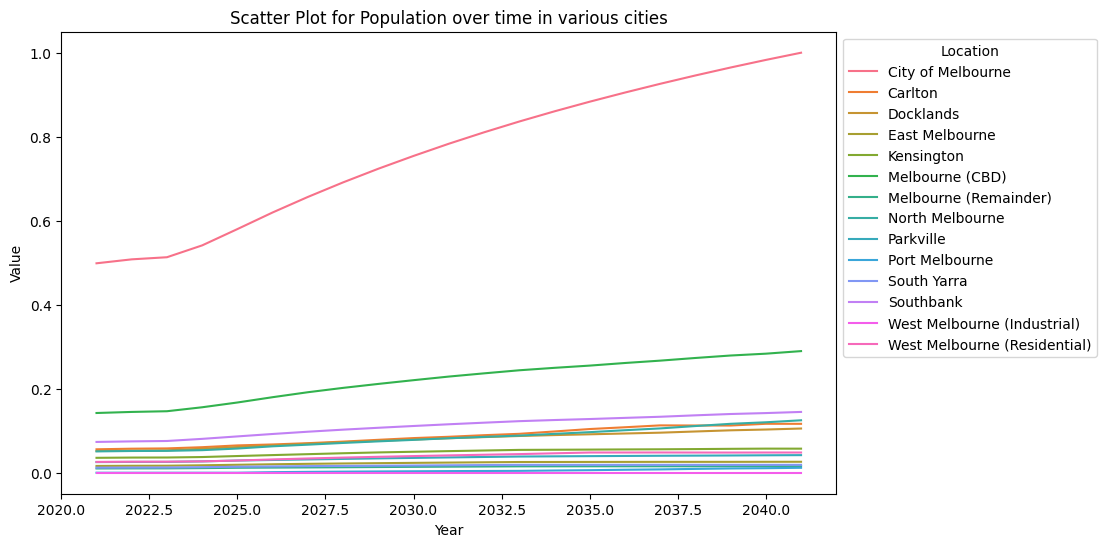

In [125]:
x = population[population.geography.isin(city_names)]


plt.figure(figsize=(10,6))
plot= sns.lineplot(data=x, x='year', y='value', hue='geography')
plt.title('Scatter Plot for Population over time in various cities')
plt.xlabel('Year')
plt.ylabel('Value')
plt.legend(title='Location')
sns.move_legend(plot, "upper left", bbox_to_anchor=(1, 1))

This scatterplot visualizes population growth trends over time for various locations within Melbourne. Here's what can be understood from the plot:
1.   The red line, representing the City of Melbourne, shows a strong upward trend, indicating a significant increase in population from 2020 to 2040
2.   The green line, representing Carlton, along with other colored lines for districts such as Docklands and East Melbourne, shows relatively stable populations over the same period. These lines are mostly flat, indicating little to no growth in population.
3.   Most of the other locations, represented by various colors, remain nearly constant over the years. This suggests that while the central area of Melbourne is growing, other districts are not experiencing similar population increases.
4.   The graph allows for an easy comparison of growth rates between the central business district and the outlying area







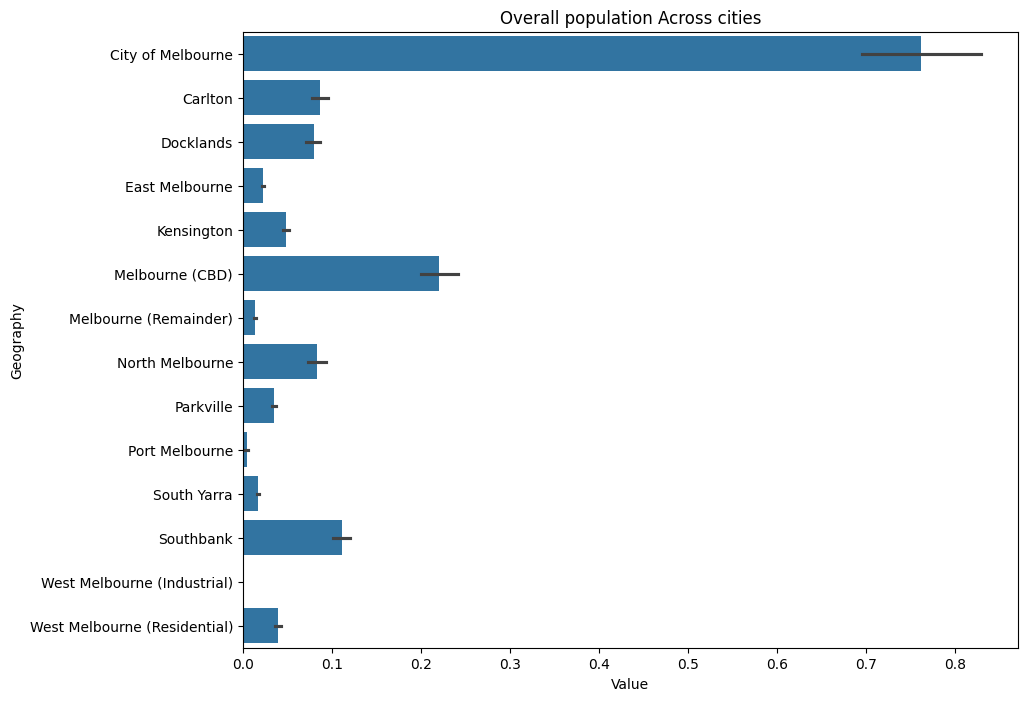

In [126]:
# bar plot
plt.figure(figsize=(10, 8))
sns.barplot(data=population, x='value', y='geography')
plt.title(f'Overall population Across cities')
plt.xlabel('Value')
plt.ylabel('Geography')
plt.show()

This bar chart shows how the population is spread across different areas in Melbourne. Here’s a breakdown of what it tells us:

1. City of Melbourne's Large Population: The City of Melbourne has a much larger population than other areas, as shown by its much longer bar.

2. Smaller Populations in Other Areas: Places like Carlton, Docklands, and Kensington have fewer people, reflected in their shorter bars.

3. Very Small Populations in Some Suburbs: Suburbs like Southbank, West Melbourne (both Industrial and Residential), and Port Melbourne have the smallest populations, as indicated by the shortest bars.

4. Focus on Infrastructure: Because the City of Melbourne has such a high population, it may need more transportation and infrastructure services. Areas with fewer people might be looked at for future development.

5. Planning for Services: Urban planners can use this data to make sure resources are allocated wisely, with high-population areas getting the services they need and considering growth in less populated areas.

Overall, the chart helps us see how people are distributed across Melbourne, which is important for planning urban development, transportation, and infrastructure.

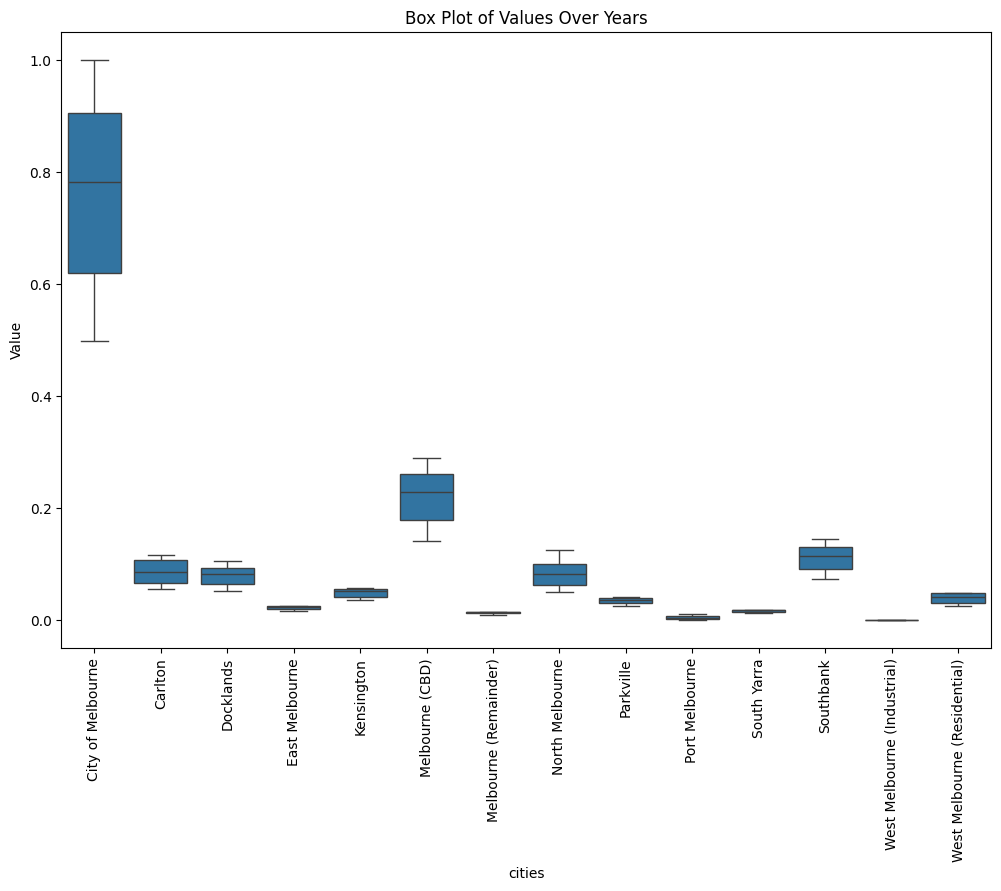

In [127]:
# Plotting box plot using seaborn
plt.figure(figsize=(12, 8))
sns.boxplot(data=population, x='geography', y='value')
plt.title('Box Plot of Values Over Years')
plt.xlabel('cities')
plt.xticks(rotation=90)
plt.ylabel('Value')
plt.show()

This box plot shows how population numbers have changed over the years in different parts of Melbourne. Here's what we can learn from it:

1. Population Variability and Range:
  *  City of Melbourne: Has a high median population around 0.8, with a range from about 0.6 to 1.0, indicating a consistently large population with little change over time.

  *   Carlton: Has a lower median population around 0.2, with very little change over time.
  *   Docklands: Similar to Carlton, with a slightly lower median and minimal variation in population.

2. Outliers and Stability:
  *   There are no outliers in any area, which means population numbers have been stable over the years in each location.
  *   Most areas, except the City of Melbourne, have very narrow boxes, showing that population numbers don’t fluctuate much and remain stable.

3. Comparative Insights:
   *   Melbourne (CBD) and City of Melbourne have higher populations compared to other areas, with Melbourne (CBD) showing more variation.
   *   Areas like Southbank, West Melbourne (Industrial), and West Melbourne (Residential) have very low population numbers, close to 0, and show little change, indicating stable but small populations.

4. Implications for Urban Planning:
   *   The high population and variability in the City of Melbourne and Melbourne (CBD) suggest these areas might require more flexible and robust urban planning and transportation solutions due to their dynamic population changes.
   *   The stable populations in areas like Carlton and Docklands indicate that while the demand might be lower, urban planning can focus on maintaining or slowly improving existing infrastructure.

Overall, this box plot is useful for identifying areas with the greatest population pressures and where populations are most stable, helping city planners make better decisions about resource allocation and future development.

<b>Tram dataset </b>
<ul>
    Initial visualization to see locations of tram stops
</ul>

In [128]:
tram_stops.head(3)

,stop_name,lat_tram,lon_tram
0,Market Street / Flinders Street,-37.819223,144.961401
1,Victoria Police Centre / Flinders Street,-37.821539,144.953569
2,Central Pier / Harbour Esplanade,-37.815427,144.945121


In [129]:
import folium

map = folium.Map(location = [tram_stops["lat_tram"].iloc[0], tram_stops["lon_tram"].iloc[0]], zoom_start=-1)

for i, rows in tram_stops.iterrows():
    folium.Marker(location=[rows["lat_tram"], rows["lon_tram"]], tooltip=rows['stop_name']).add_to(map)

min_val = tram_stops[['lat_tram', 'lon_tram']].min().values.tolist()
max_val = tram_stops[['lat_tram', 'lon_tram']].max().values.tolist()

map.fit_bounds([min_val, max_val])


map

 After setting the markers and fitting the bounds, display the map to visualize the tram stops and This process provides a clear, interactive visualization of tram stops within the map

<b>Metro station dataset </b>
<ul>
    Initial visualization to see locations of metro station stops
</ul>

In [130]:
metro_station.head()

,station_name,lat_metro,lon_metro
0,Alphington,-37.778396,145.031251
1,Altona,-37.867249,144.830604
2,Anstey,-37.761898,144.960561
3,Auburn,-37.822411,145.045617
4,Batman,-37.733459,144.962747


In [131]:
map = folium.Map(location = [metro_station["lat_metro"].iloc[0], metro_station["lon_metro"].iloc[0]], zoom_start=10)

for i, rows in metro_station.iterrows():
    folium.Marker(location=[rows["lat_metro"], rows["lon_metro"]], tooltip=rows['station_name']).add_to(map)

min_val = metro_station[['lat_metro', 'lon_metro']].min().values.tolist()
max_val = metro_station[['lat_metro', 'lon_metro']].max().values.tolist()

map.fit_bounds([min_val, max_val])


map

We are visualizing metro stations on a map using Folium which is well-structured and the map is displaying with all metro stations marked and the view fitted to show all stations

<b>Bus Stops dataset </b>
<ul>
    Initial visualization to see locations of Bus stops
</ul>

In [132]:
bus_stops.head()

,lat_bus,lon_bus
0,-37.803842,144.932393
1,-37.815487,144.958179
2,-37.813539,144.957283
3,-37.821914,144.955393
4,-37.833164,144.974437


In [133]:
map = folium.Map(location = [bus_stops["lat_bus"].iloc[0], bus_stops["lon_bus"].iloc[0]], zoom_start=10)

for i, rows in bus_stops.iterrows():
    folium.Marker(location=[rows["lat_bus"], rows["lon_bus"]]).add_to(map)

min_val = bus_stops[['lat_bus', 'lon_bus']].min().values.tolist()
max_val = bus_stops[['lat_bus', 'lon_bus']].max().values.tolist()

map.fit_bounds([min_val, max_val])


map

This code visualizes bus stops on a map, marking each stop's location. It dynamically adjusts the map view to ensure all stops are visible, and tooltips can be added to show the names of the bus stops when hovering over the markers.

<h4>combining transport and popualtion map to visualize it on a single map<h4>

<b>Population dataset </b>

The code below extracts latitude and longitude from the datasets and locates them on the map. If a specific location can't be identified, it outputs a "CITY NOT FOUND" message. A new dataframe is then created to store the latitude, longitude, and the corresponding city name.

In [134]:
population.head(5)

,geography,year,value
8946,City of Melbourne,2021,0.498634
8947,City of Melbourne,2025,0.580116
8948,City of Melbourne,2028,0.691288
8949,City of Melbourne,2029,0.723781
8950,City of Melbourne,2033,0.836179


In [135]:
geolocator = Nominatim(user_agent="location_details")

new_df = pd.DataFrame()

city_list = list()
lat_list = list()
long_list = list()

for city in population.geography.unique():
    city = f"{city}, Victoria, Australia"
    try:
        location = geolocator.geocode(city)
        # print((location.address,  location.latitude, location.longitude))
        lat_list.append(location.latitude)
        long_list.append(location.longitude)
        # print()
        city_list.append(location.address.split(",")[0])
        map=folium.Map(location=[location.latitude, location.longitude],zoom_start=15)
        map.add_child(folium.Marker(location=[location.latitude, location.longitude],popup=location,icon=folium.Icon(color='blue')))

    except:
        print(f"CITY NOT FOUND: {city}")


new_df['geography'] = np.array(city_list)
new_df['city_lat']   = np.array(lat_list)
new_df['city_long'] = np.array(long_list)


new_df
pop_la = new_df
pop_la



CITY NOT FOUND: Melbourne (Remainder), Victoria, Australia
CITY NOT FOUND: West Melbourne (Residential), Victoria, Australia


,geography,city_lat,city_long
0,City of Melbourne,-37.812382,144.948265
1,Carlton,-37.800423,144.968434
2,Docklands,-37.817542,144.939492
3,East Melbourne,-37.812498,144.985885
4,Kensington,-37.793938,144.930565
5,Melbourne,-37.814171,144.965562
6,North Melbourne,-37.807609,144.942351
7,Parkville,-37.787115,144.951553
8,Port Melbourne,-37.833361,144.921920
9,South Yarra,-37.837770,144.991854


In [136]:
# combining transport and popualtion map to visualize it on a single map
map = folium.Map(zoom_start=10)

# to show the bus stops
for i, rows in bus_stops.iterrows():
    folium.Marker(location=[rows["lat_bus"], rows["lon_bus"]],icon=folium.Icon(color='blue')).add_to(map)

# To show teh metro stops
for i, rows in metro_station.iterrows():
    folium.Marker(location=[rows["lat_metro"], rows["lon_metro"]], icon=folium.Icon(color='orange')).add_to(map)


for i, rows in pop_la.iterrows():
    folium.Marker(location=[rows["city_lat"], rows["city_long"]], icon=folium.Icon(color='green')).add_to(map)



min_val = bus_stops[['lat_bus', 'lon_bus']].min().values.tolist()
max_val = bus_stops[['lat_bus', 'lon_bus']].max().values.tolist()

map.fit_bounds([min_val, max_val])


map

<b>Data Preprocessing for population dataset</b>

<p>In this section, we will further process the data to prepare it for input into models and networks. Properly preprocessed data can greatly improve the performance and accuracy of machine learning models. In the code block below, we expand the population dataset to display population values for each city for every given year. We will also remove the "City of Melbourne" feature, as it is not recognized as a city in the Small CLUE areas documentation. Since we've already handled missing values and applied scaling earlier, we won't repeat those steps here. Additionally, there are no categorical variables, so encoding is not needed. We'll also ensure that the data is in the correct format, as many models require specific formatting.</p>

In [137]:
population=population.pivot_table(index="year", columns="geography", values="value", aggfunc='first')
population=population.drop(['City of Melbourne'],axis=1)

In [138]:
population.head(5)

geography,Carlton,Docklands,East Melbourne,Kensington,Melbourne (CBD),Melbourne (Remainder),North Melbourne,Parkville,Port Melbourne,South Yarra,Southbank,West Melbourne (Industrial),West Melbourne (Residential)
year,,,,,,,,,,,,,
2021,0.055761,0.051676,0.016120,0.035475,0.142201,0.010127,0.050790,0.025351,0.000032,0.012057,0.073296,0.0,0.025747
2022,0.057202,0.052636,0.016519,0.036072,0.144739,0.010302,0.051715,0.025708,0.000032,0.012281,0.074626,0.0,0.026205
2023,0.057886,0.053334,0.016694,0.036234,0.146416,0.010386,0.052030,0.025789,0.000032,0.012434,0.075551,0.0,0.026289
2024,0.060771,0.057046,0.017697,0.037344,0.155845,0.010971,0.053701,0.026948,0.000036,0.013239,0.080619,0.0,0.027077
2025,0.065028,0.061157,0.018923,0.039738,0.167209,0.011772,0.057585,0.028982,0.000039,0.014193,0.086469,0.0,0.029028


In [164]:
population_act = population.copy()

In [165]:
population.columns = population.columns.astype(str)
population=population.reset_index()
# formatting the year column as datetime and setting it as index
population.year = pd.to_datetime(population.year, format="%Y")
population.set_index('year', inplace =True)

In [166]:
population.head()

geography,index,Carlton,Docklands,East Melbourne,Kensington,Melbourne (CBD),Melbourne (Remainder),North Melbourne,Parkville,Port Melbourne,South Yarra,Southbank,West Melbourne (Industrial),West Melbourne (Residential)
year,,,,,,,,,,,,,,
2021-01-01,0,0.055761,0.051676,0.016120,0.035475,0.142201,0.010127,0.050790,0.025351,0.000032,0.012057,0.073296,0.0,0.025747
2022-01-01,1,0.057202,0.052636,0.016519,0.036072,0.144739,0.010302,0.051715,0.025708,0.000032,0.012281,0.074626,0.0,0.026205
2023-01-01,2,0.057886,0.053334,0.016694,0.036234,0.146416,0.010386,0.052030,0.025789,0.000032,0.012434,0.075551,0.0,0.026289
2024-01-01,3,0.060771,0.057046,0.017697,0.037344,0.155845,0.010971,0.053701,0.026948,0.000036,0.013239,0.080619,0.0,0.027077
2025-01-01,4,0.065028,0.061157,0.018923,0.039738,0.167209,0.011772,0.057585,0.028982,0.000039,0.014193,0.086469,0.0,0.029028


<h4> Linear Regression</h4>

<p> Applying Linear Regression to the population dataset allows us to analyze population growth across different geographic areas. We expect the growth to follow a linear trend over time, assuming there are no significant demographic changes. By using linear regression, we can estimate the rate of population increase or decrease in various cities over time. To evaluate the performance of our training set on the new test data, we use metrics like Mean Squared Error (MSE) and R-squared. MSE measures the average squared difference between the actual values and the predicted values. A lower MSE indicates that the model's predictions are closer to the actual data points, resulting in a better fit for new, unseen data. R-squared is a statistical metric that shows the proportion of the variance in the dependent variable that can be explained by the independent variable.</p>

In [167]:
population_act = population_act.reset_index()

In [169]:
# Ensure 'year' is in integer format
population_act['year'] = pd.to_datetime(population_act['year']).dt.year


In [170]:

# Preparing the data for the model
x = population_act.year.values.reshape(-1, 1)
y = population_act.Southbank.values.reshape(-1, 1)

# Split the data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=42)

# Train the model
model_lr = LinearRegression().fit(x_train, y_train)

# Predict using the model
y_pred = model_lr.predict(x_test)

# Output predictions
y_pred


array([[0.07332273],
       [0.13762662],
       [0.13006146],
       [0.07710531],
       [0.10358338],
       [0.09223564],
       [0.11493113]])

In [171]:
mse = mean_squared_error(y_test, y_pred)
print(f"MSE is {mse}")
r2 = r2_score(y_test, y_pred)
print(f"R^2 score is {r2}")

MSE is 5.260197397239184e-06
R^2 score is 0.9906785317626453
